In [1]:
import torch

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

In [3]:
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)

In [9]:
image_path = "./assets/images/test_image.jpg"
image = Image.open(image_path)
width, height = image.size
inference_state = processor.set_image(image)

found 12 object(s)


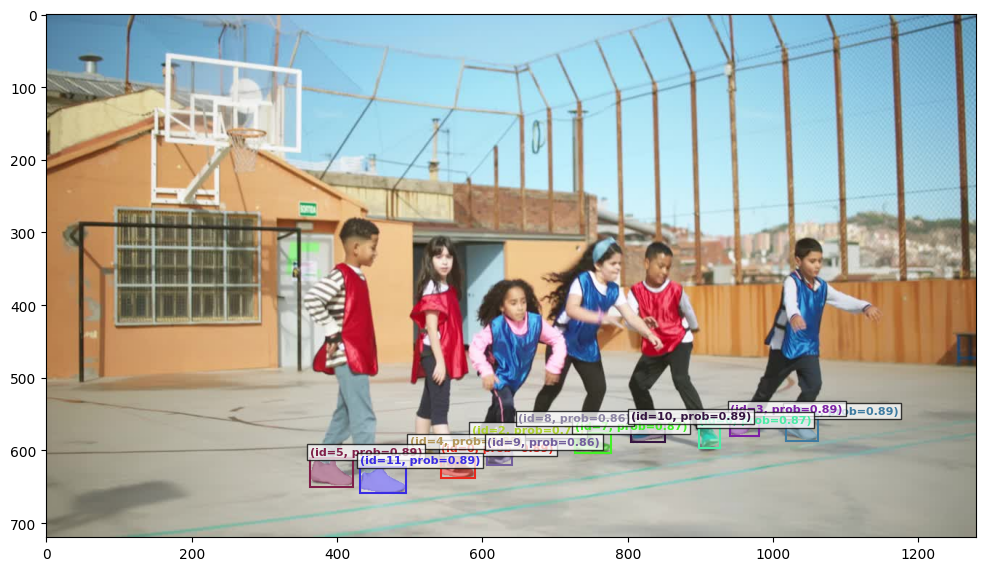

In [10]:
prompt="shoe"
output = processor.set_text_prompt(state=inference_state, prompt=prompt)

img0 = Image.open(image_path)
plot_results(img0, output)

Normalized box input: [0.41796875, 0.6527777910232544, 0.0859375, 0.5]


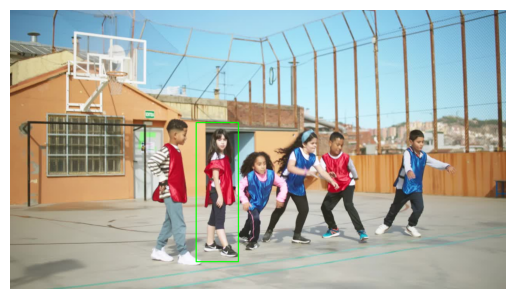

In [11]:
box_input_xywh = torch.tensor([480.0, 290.0, 110.0, 360.0]).view(-1, 4)
box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
print("Normalized box input:", norm_box_cxcywh)

processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(
    state=inference_state, box=norm_box_cxcywh, label=True
)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
plt.imshow(image_with_box)
plt.axis("off")  # Hide the axis
plt.show()

found 6 object(s)


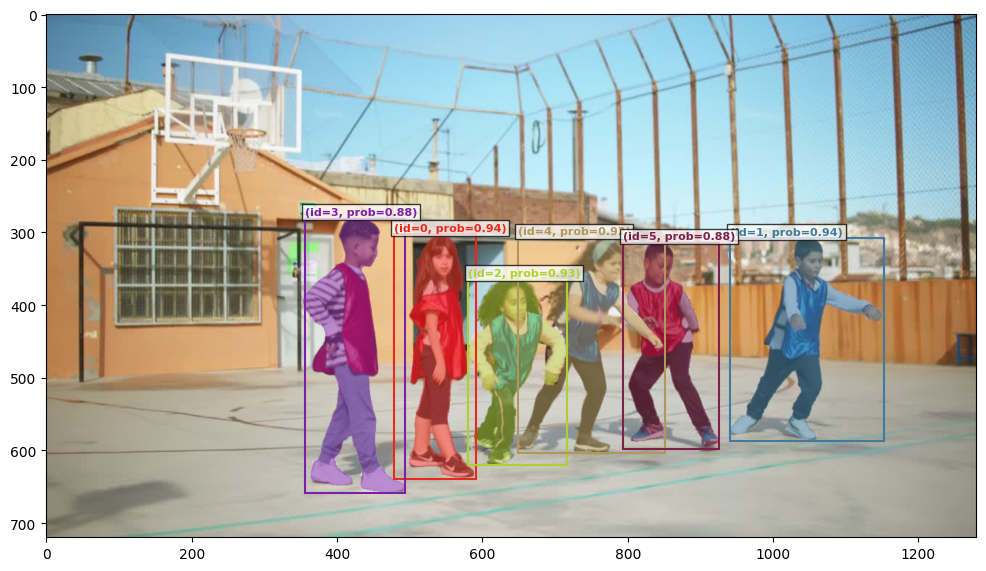

In [12]:
plot_results(img0, inference_state)